# News Category Dataset

## Objetivo
Artigos de notícias de gêneros diferentes têm estilos de escrita diferentes?
O objetivo do trabalho é identificar o tipo de gênero com base em manchetes e descrições curtas utilizando técnicas de Machine Learning e NLP(Natural Linguage Processing). A aplicação da categorização de texto visa filtrar um fluxo de notícias para um determinado grupo de interesse.


![noticias](jornais.jpg)


Este conjunto de dados contém cerca de 200 mil manchetes de notícias do ano de 2012 a 2018 obtidas no HuffPost. HuffPost é um site americano sobre opiniões e notícias como política, cultura, bem-estar, etc. Foi fundado em 2005 por Andrew Breitbart, Arianna Huffington, Kenneth Lerer e Jonah Peretti.

Link para o dataset: https://www.kaggle.com/rmisra/news-category-dataset

## Descrição das Features
- **category**: Variável alvo, representa o gênero da notícia; 
- **headline**: Manchete da notícia;
- **authors**: Identifica o autor que escreveu a notícia;
- **Link**: Endereço da notícia na web;
- **short_description**: Pequena descrição da notícia;
- **date**: Data em que a notícia foi postada.

## Importação das bibliotecas

In [1]:
import numpy as np # operações algébricas 
import pandas as pd # processamento de dados

import matplotlib.pyplot as plt # visualização de dados
import seaborn as sns # visualização de dados
from wordcloud import WordCloud
%matplotlib inline

import re  # expressões regulares
import nltk # processamento de linguagem natural
from nltk import FreqDist
from nltk.stem.porter import PorterStemmer # stemmização

from sklearn.feature_extraction.text import CountVectorizer # representação do texto em forma matricial 
# - bag of words

from sklearn.feature_extraction.text import TfidfVectorizer # representação tf-idf

from sklearn.metrics import accuracy_score, recall_score, precision_score # métricas
from sklearn.metrics import classification_report # métricas

from sklearn.preprocessing import LabelEncoder # codificação

from sklearn.model_selection import StratifiedKFold # cross-validation stratificada

from sklearn.model_selection import train_test_split # divisão dos dados

from sklearn.naive_bayes import MultinomialNB, GaussianNB, BernoulliNB # modelo de previsão utilizado - prob
from sklearn.linear_model import LinearRegression # modelo linear
from sklearn.svm import SVC # modelo linear

In [2]:
import warnings
warnings.filterwarnings("ignore")

## Leitura dos dados

In [3]:
df = pd.read_json('News_Category_Dataset_v2.json', lines=True)

## Remoção de Features

As features não serão utilizadas para a classificação, serão utilizadas apenas as features do tipo texto. 

In [4]:
df = df.drop(labels=['link', 'date', 'authors'], axis=1)

## Estrutura e Descrição dos Dados

### Visão parcial do dataset

In [5]:
df.sample(5)

,category,headline,short_description
180310,WELLNESS,"Ginkgo Biloba Doesn't Prevent Alzheimer's, Stu...","""For a while it was hoped that ginkgo biloba c..."
184473,STYLE & BEAUTY,Beverly Johnson Looks Gorgeous While Modeling ...,Dirck Halstead/Time & Life Pictures It's no su...
186705,PARENTING,Tips for Planning Your Child's Next Birthday P...,Enjoy this big milestone in your child's life....
108003,PARENTS,A Halloween Parenting Tip,She was the cutest baby that had ever been con...
40377,HEALTHY LIVING,Florida No Longer Has Any Active Zika Virus Tr...,There have been no new cases of local transmis...


### Informações gerais do dataset

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200853 entries, 0 to 200852
Data columns (total 3 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   category           200853 non-null  object
 1   headline           200853 non-null  object
 2   short_description  200853 non-null  object
dtypes: object(3)
memory usage: 4.6+ MB


### Estatísticas Básicas

In [7]:
df.describe()

,category,headline,short_description
count,200853,200853,200853
unique,41,199344,178353
top,POLITICS,Sunday Roundup,
freq,32739,90,19712


###  Quantidade de gênero de notícias

In [8]:
df['category'].nunique()

41

### Lista de gêneros e a quantidade de notícias associadas a ela

A quantidade de gêneros está bastante desbalanceada.

In [9]:
df['category'].value_counts()

POLITICS          32739
WELLNESS          17827
ENTERTAINMENT     16058
TRAVEL             9887
STYLE & BEAUTY     9649
PARENTING          8677
HEALTHY LIVING     6694
QUEER VOICES       6314
FOOD & DRINK       6226
BUSINESS           5937
COMEDY             5175
SPORTS             4884
BLACK VOICES       4528
HOME & LIVING      4195
PARENTS            3955
THE WORLDPOST      3664
WEDDINGS           3651
WOMEN              3490
IMPACT             3459
DIVORCE            3426
CRIME              3405
MEDIA              2815
WEIRD NEWS         2670
GREEN              2622
WORLDPOST          2579
RELIGION           2556
STYLE              2254
SCIENCE            2178
WORLD NEWS         2177
TASTE              2096
TECH               2082
MONEY              1707
ARTS               1509
FIFTY              1401
GOOD NEWS          1398
ARTS & CULTURE     1339
ENVIRONMENT        1323
COLLEGE            1144
LATINO VOICES      1129
CULTURE & ARTS     1030
EDUCATION          1004
Name: category, 

## Remoção e agregação de categorias

### Agregação

Algumas categorias por possuirem conteúdo semelhante são agregadas. 

In [10]:
map_rep = {'HEALTHY LIVING' : 'LIVING', 'HOME & LIVING' : 'LIVING', 'STYLE' : 'STYLE & BEAUTY' }

df['category'].replace(map_rep, inplace=True)

### Remoção

O conjunto de dados possue muitas categorias, além disso, algumas categorias tem poucos registros, gerando um grande desbalanceamento. Afim de melhorar a classificação foram deixados apenas as 6 categorias de notícias com a maior quantidade de registros no dataset.

In [11]:
# genêros com a maior quantidade de notícias 
categories = ['POLITICS', 'WELLNESS', 'ENTERTAINMENT', 'TRAVEL', 'STYLE & BEAUTY', 'LIVING']

df = df[df['category'].isin(categories)]

# nova distribuição
df['category'].value_counts()

POLITICS          32739
WELLNESS          17827
ENTERTAINMENT     16058
STYLE & BEAUTY    11903
LIVING            10889
TRAVEL             9887
Name: category, dtype: int64

In [12]:
df.shape

(99303, 3)

## Limpeza dos Dados

A limpeza é utilizada com o intuito de deixar os dados mais adequados para a utilização de algoritmos de machine learning.

### Valores duplicados

Registros duplicados podem acontecer por diversos motivos, entrada repetida de dados, dados coletados erroneamente. Com dados textuais é menos frequente  de acontecer, para melhorar o processamento, esses documentos repetidos são removidos, deixando apenas uma única unidade de cada.

In [13]:
df[df[['headline', 'short_description']].duplicated()]

,category,headline,short_description
10335,ENTERTAINMENT,"With This 'Shape Of Water' Clip, You'll Fall F...",Spencer and Sally Hawkins play 1960s janitors ...
10395,POLITICS,Abortion Isn’t Main Reason More Republicans St...,Would the Democrats’ Alabama Senate candidate ...
10429,STYLE & BEAUTY,The Worst Beauty Trends Of 2017,"Bye-bye, glitter butts."
10514,POLITICS,The 'Alt-Lite' White House Reporter Who Got Ar...,The former Proud Boy marched with white suprem...
11082,POLITICS,The Best Chance To Defeat Roy Moore May Be For...,Democrat Doug Jones is trying to distinguish h...
...,...,...,...
199422,STYLE & BEAUTY,BAFTAs 2012 Red Carpet Roundup: Understated Ch...,"It's the eleventh hour for Hollywood style, wi..."
199433,STYLE & BEAUTY,"Whitney Houston Dies, Her Glittering Style Rem...","And within the fashion world, of course, Whitn..."
199444,STYLE & BEAUTY,BAFTAs 2012 Red Carpet Roundup: Understated Ch...,"It's the eleventh hour for Hollywood style, wi..."
199962,LIVING,Weekly Roundup of eBay Vintage Home Finds (PHO...,"As always, buyer beware! Be sure to read the l..."


In [14]:
df[['headline', 'short_description']].drop_duplicates(inplace=True)

### Agregação dos dados

É feita a junção do texto das features ```headline``` e ```short_description``` afim de deixar todo o texto segmentado em apenas uma nova feature, com isso vários registros sem descrições agora terão o texto tanto do título como o da manchete e serão aproveitados para  a previsão.

In [15]:
# junção das features headline + short_description
df2 = {'text' : df['headline'].values + ' ' + df['short_description'].values, 'category' : df.category.values}

# criação do novo dataset
df2 = pd.DataFrame(df2)

# visão parcial
df2.sample(5)

,text,category
57419,Distressed Denim Has Officially Gone Too Far,STYLE & BEAUTY
58944,Choosing Psychotherapy Today: One Size No Long...,WELLNESS
30905,New York Nail Salons Ordered To Pay Compensati...,POLITICS
20301,'Star Wars' Won't Digitally Resurrect Carrie F...,ENTERTAINMENT
34447,Dems Plan To Make Republicans Pay For Blockadi...,POLITICS


### Tratamento de Emojis

Os emojis são um empecilho para a análise de texto. É criado uma expressão regular que irá removê-los do texto de cada registro.

In [16]:
# a seguinte expressão sera usada para a eliminação de emojis do texto
emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002500-\U00002BEF"  # chinese char
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               u"\U0001f926-\U0001f937"
                               u"\U00010000-\U0010ffff"
                               u"\u2194-\u23FA"
                               u"\u2640-\u2642"
                               u"\u2600-\u2B55"
                               u"\u200d"
                               u"\u23cf"
                               u"\u23e9"
                               u"\u231a"
                               u"\ufe0f"  # dingbats
                               u"\u3030"
                               u"\u000020E3"
                               u"\u2B1C"
                               "]+", flags=re.UNICODE)

In [17]:
# a função remove os emojis do texto
def remover_emojis(data):
    return [emoji_pattern.sub(r'', data[i]) for i in range(data.shape[0])]

In [18]:
# remoção de emojis
df2['text'] = remover_emojis(df2['text'])

### Remoção de caracteres

Caracteres e pontuações são removidas do texto a fim de melhorar o desempenho da previsão.

In [19]:
# a função remove caracteres indesejados
def remover_caracteres(data):
    return [re.sub(r'[!-/]|[:-@]|[{-~]|[0-9]|\¯\\__/¯', '', data[i]) for i in range(data.shape[0])]

In [20]:
# remoção de caracteres
df2['text'] = remover_caracteres(df2['text'])

### Padronização do texto

- Remoção dos espaços extras das strings
- Padronização em caixa baixa das strings

In [21]:
# remove espaços no inicio e no fim de cada descrição da notícia
df2['text'] = df2['text'].str.strip()

# padroniza as strings em caixa baixa
df2['text'] = df2['text'].str.lower()

### Valores faltantes

Como a quantidade de registros com valores faltantes é ínfima, apenas a remoção é utilizada para lidar com esse problema.

In [22]:
df2[df2['text'] == '']

,text,category
41819,,POLITICS
53544,,LIVING


In [23]:
df2.drop(axis=0, index=df2[df2['text'] == ''].index, inplace=True)

### Tokenização
A tokenização é um processo pelo o qual transforma a string (frase, texto) em uma sequência de tokens. Cada token pode então ser contado como uma palavra.

Aqui a tokenização será utilizada para a contabilidade da frequência de palavras no documento.

A função abaixo transforma cada registro em uma lista de tokens (palavras).

In [24]:
df2['text'] = df2['text'].apply(lambda text: text.split())

### Frequência de palavras

É feita a contagem de palavras distribuídas nos registros e o número de vezes que cada uma se repete pelo dataset.

In [25]:
def qtd_words(df):
    words = []
    for list_words in df:
        words.extend(list_words)
    return words

In [26]:
# lista das palavras antes de sofrerem a stemmização e a remoção das stopwords
words = qtd_words(df2['text'])

### Stop Words

A classificação não requer uma profunda compreensão do texto, para este tipo de tarefa, pronomes, artigos e preposições não agregam valor, palavras sem valor para o texto são removidas e são deixadas apenas aquelas palavras que dêem um significado para a classificação do texto.

In [27]:
def remove_stop_words(df):
    # conjunto de palavras que são consideradas 'stopwords' na lingua inglesa
    stopwords = nltk.corpus.stopwords.words("english")
    return [word for word in df if word not in stopwords]

In [28]:
# aplicação da função para a remoção das stopwords
df2['text_p1'] = df2['text'].apply(remove_stop_words)

In [29]:
# lista de palavras após o dataset ter removido as stopwords
words_v2 = qtd_words(df2['text_p1'])

### Stemmização

Stemming é uma tarefa de NPL que tenta reduzir cada palavra à sua forma de radical linguística básica.

In [30]:
df2['text_p2'] = df2['text_p1'].apply(lambda words: [PorterStemmer().stem(word) for word in words])

In [31]:
# lista de palavras após a remoção das stopwords e a aplicação da stemmização no dataset 
words_v3 = qtd_words(df2['text_p2'])

### Análise após processamento

In [32]:
vector_words, vector_titles = [words, words_v2, words_v3], ['Sem Modificação', 'Sem StopWords', 'Stemmizadas']

for w_, t_ in zip(vector_words, vector_titles):
    print(f'{t_}')
    print(f"Quantidade de palavras:{len(w_)}")
    print(f"Quantidade de palavras distintas:{len(set(w_))}")
    print()

Sem Modificação
Quantidade de palavras:2879425
Quantidade de palavras distintas:78358

Sem StopWords
Quantidade de palavras:1745591
Quantidade de palavras distintas:78220

Stemmizadas
Quantidade de palavras:1745591
Quantidade de palavras distintas:55392



### Nuvem de Palavras

In [33]:
def cloud_(df, column, cat):
    text = []
    
    for doc in df[df['category'] == cat][column].values:
        text.extend(doc)

    wordcloud = WordCloud(width=1600, height=750, 
                          max_font_size=230,
                          max_words=100,
                          background_color="black",
                          stopwords='', 
                          collocations=False).generate(' '.join(text))
    
    plt.figure(figsize=(12,10))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()

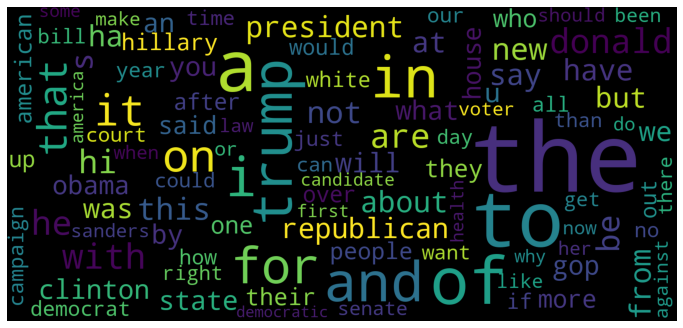

In [34]:
cloud_(df2, 'text', 'POLITICS')

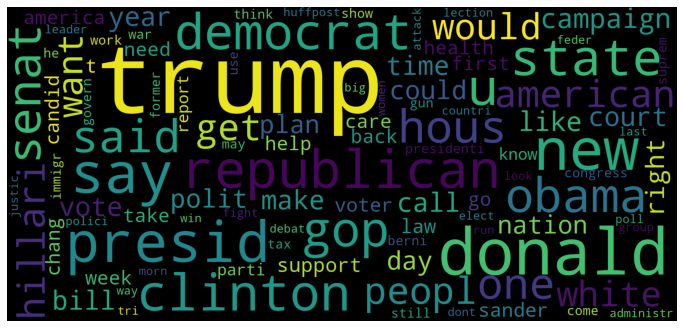

In [35]:
cloud_(df2, 'text_p2', 'POLITICS')

### Transformando as listas de palavras em strings

In [36]:
df2['text_p2'] = df2['text_p2'].apply(lambda x: ' '.join(x))

### Encoding das labels

Alguns algoritmos não aceitam variáveis do tipo categórica, para contornar isso é feita a codificação delas.

In [37]:
encoder = LabelEncoder()
df2['category'] = encoder.fit_transform(df2['category'])

#### Mapeamento 

In [38]:
generos_ = list(enumerate(encoder.classes_))
generos_

[(0, 'ENTERTAINMENT'),
 (1, 'LIVING'),
 (2, 'POLITICS'),
 (3, 'STYLE & BEAUTY'),
 (4, 'TRAVEL'),
 (5, 'WELLNESS')]

## Treinamento do Modelo

### Divisão dos dados

In [39]:
X =  df2['text_p2'].values
y =  df2['category'].values

## Vetorização
A vetorização de textos consiste na representação de um texto na forma de um vetor de termos. Esta é a etapa em que as palavras são convertidas em números e assim podem ser processados pelos algoritmos. 

## Bag of words

Um documento de texto é convertido em um vetor de contagens, o vetor contém uma entrada para cada palavra possível no vocabulário.

### CountVectorizer

Count Vectorizer é uma notação de matriz do conjunto de dados em que cada linha representa um registro do dataset, cada coluna representa um termo (palavra) presente no dataset e cada célula representa a contagem de frequência de um determinado termo em um determinado registro.

In [40]:
vectorizer = CountVectorizer()

X_bow = vectorizer.fit_transform(X)

### TF-IDF

Uma representação bem popular para texto, é o produto de Frequência do Termo (**TF**) e da Frequência do documento inversa (**IDF**).

- Frequência do termo (**TF**) – É a frequência das palavras em um texto.
- Frequência inversa de documento  (**IDF**) - Incremento que um termo recebe por ser raro.

**Fórmula da IDF**:

<i>t -> termo (palavra)</i>

$$
IDF(t) = 1 + \log{\Bigr(\frac{número\ total \ de \ documentos}{número\ de\ dumentos\ contendo\ t}\Bigr)}
$$
<br>
Quando usamos ambos os **TF** e **IDF** juntos (**TF X IDF**), as palavras de alta frequência em um texto  que tem baixa ocorrência em outros textos recebem maior importância. A abordagem **TF-IDF** torna as palavras raras mais proeminentes e efetivamente ignora palavras comuns.



In [41]:
tf = TfidfVectorizer()

X_tf = tf.fit_transform(X)

## Construção dos Modelos

Após as etapas de pré-processamento, engenharia de features e vetorização, os dados estão prontos para serem submetidos a algoritmos de Machine Learning.

###  Naive Bayes Classifier

Os métodos Naive Bayes são um conjunto de algoritmos de aprendizagem supervisionada com base na aplicação do teorema de Bayes com a suposição "ingênua" de independência condicional entre cada par de recursos dado o valor da variável de classe.

Os classificadores Bayes ingênuos funcionam muito bem em muitas situações do mundo real, como a classificação de documentos e filtragem de spam.

#### MultinomialNB
Implementa o algoritmo Bayes ingênuo para dados distribuídos multinomialmente e é uma das duas variantes Bayes ingênuas clássicas usadas na classificação de texto.
    
Para saber mais, acesse: https://nlp.stanford.edu/IR-book/html/htmledition/naive-bayes-text-classification-1.html

#### BernoulliNB
Gera um indicador para cada termo do vocabulário, seja $ 1 $ indicando a presença do termo no documento ou $ 0 $ indicando ausência.

Para saber mais, acesse: https://nlp.stanford.edu/IR-book/html/htmledition/the-bernoulli-model-1.html

### K-fold cross-validation

Na validação cruzada **k-fold**, dividimos aleatoriamente o conjunto de dados de treinamento em **k folds** sem substituição, onde **k - 1** folds são usados para o treinamento do modelo e um **fold** é usado para avaliação de desempenho. Este procedimento é repetido **k vezes** para que obtenhamos **k modelos** e estimativas de desempenho.

- Foram usados 10 **folds**, ou seja, 10 iterações, em cada iteração, nove **folds** para treinamento e um **fold** para teste
- É Utilizado a variação **Stratified k-fold cross-validation**

Na validação cruzada estratificada, as proporções do rótulo da classe são preservadas em cada **fold** para garantir que cada **fold** seja representativo das proporções da classe no conjunto de dados de treinamento.

In [42]:
def report_model(clf, X_, y_):
    
    kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

    recall = []
    precision = []
    acuracia = []

    for i, (train_index, test_index) in enumerate(kf.split(X_, y_)):
        X_train, X_test = X_[train_index], X_[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        # treino do modelo
        clf.fit(X_train, y_train)

        # previsão
        y_pred = clf.predict(X_test)
        
        # armazena os valores de recall
        recall.append(recall_score(y_test, y_pred, average=None))
        
        # armazena a precisão de classificação para cada classe
        precision.append(precision_score(y_test, y_pred, average=None))
        
        # armazena a acurácia de classificação para cada fold
        acuracia.append(accuracy_score(y_test, y_pred))

    return pd.DataFrame({'Precisão' : np.mean(precision, axis=0),
         'Revocação' : np.mean(recall, axis=0)} , index=encoder.classes_), np.mean(acuracia)

## Resultados

In [43]:
# bernoulli com a representação count vectorizer
avac_bernoulli_bow, acc_bernoulli_bow = report_model(BernoulliNB(), X_bow, y)

# bernoulli com a representação tf-idf
avac_bernoulli_tf, acc_bernoulli_tf_idf = report_model(BernoulliNB(), X_tf, y)

# multinomial com a representação count vectorizer
avac_multinomial_bow, acc_multinomial_bow = report_model(MultinomialNB(), X_bow, y)

# multinomial com a representação tf-idf
avac_multinomial_tf, acc_multinomial_tf_idf = report_model(MultinomialNB(), X_tf, y)

In [44]:
# resultados dos cálculos de precisão e recall para cada modelo e representação vetorial respectivamente
modelos_report = [avac_bernoulli_bow, avac_bernoulli_tf, avac_multinomial_bow, avac_multinomial_tf]

# nomes dos modelos utilizados
modelos_names = ['Bernoulli - BoW', 'Bernoulli TF-IDF', 'MultinomialNB - BoW', 'MultinomialNB TF-IDF']

report = pd.concat(modelos_report).reset_index()
report['Modelos'] = [i for i in modelos_names for _ in range(6)]
report.rename(columns={'index' : 'Category'}, inplace=True)

,Category,Precisão,Revocação,Modelos
0,ENTERTAINMENT,0.805862,0.863121,Bernoulli - BoW
1,LIVING,0.689776,0.385745,Bernoulli - BoW
2,POLITICS,0.896043,0.948867,Bernoulli - BoW
3,STYLE & BEAUTY,0.886399,0.778040,Bernoulli - BoW
4,TRAVEL,0.863585,0.773744,Bernoulli - BoW


### Precisão e Revocação por Categoria

In [45]:
report.groupby('Category').mean().sort_values('Precisão', ascending=False)

,Precisão,Revocação
Category,,
POLITICS,0.878338,0.955892
STYLE & BEAUTY,0.878086,0.783019
TRAVEL,0.872986,0.762214
ENTERTAINMENT,0.835139,0.831532
LIVING,0.744887,0.347699
WELLNESS,0.692343,0.889844


### Precisão e Revocação por Modelo

In [46]:
report.groupby('Modelos').mean().sort_values('Precisão', ascending=False)

,Precisão,Revocação
Modelos,,
MultinomialNB TF-IDF,0.837670,0.715962
MultinomialNB - BoW,0.811078,0.786166
Bernoulli - BoW,0.809552,0.772336
Bernoulli TF-IDF,0.809552,0.772336


## Acurácia

É a quantidade de previsões que são de fato classificadas corretamente, independente da classe.

In [114]:
acuracia = [acc_bernoulli_bow, acc_bernoulli_tf_idf, acc_multinomial_bow, acc_multinomial_tf_idf]

pd.DataFrame({'Modelo': modelos_names, 'Acurácia': acuracia}).sort_values(by='Acurácia', ascending=False)

,Modelo,Acurácia
2,MultinomialNB - BoW,0.829800
0,Bernoulli - BoW,0.823788
1,Bernoulli TF-IDF,0.823788
3,MultinomialNB TF-IDF,0.791553


## Visualização Gráfica

### Precisão 
Precisão é uma métrica utilizada para calcular a quantidade de casos que foram classificados como positivos que realmente são positivos. Quanto maior a precisão, menor o número de erros positivos falsos cometidos pelo classificador.

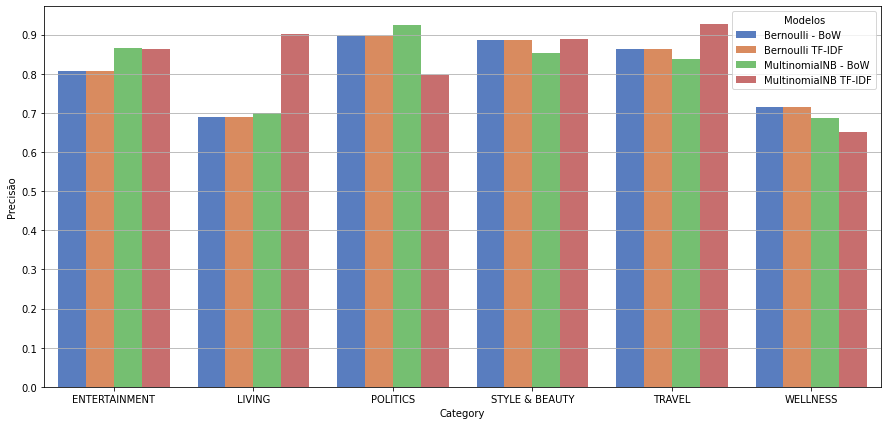

In [115]:
plt.figure(figsize=(15, 7))
plt.grid()
plt.yticks(np.arange(0.0, 1.1, 0.1))
sns.barplot(x='Category', y='Precisão', hue='Modelos', data=report, palette='muted');
plt.savefig('precisão.png')

###  Recall

Recall, também conhecida por Revocação, é a taxa de verdadeiros positivos, é a contagem de instâncias positivas que são corretamente detectadas pelo classificador. Classificadores com recall alta têm muito poucos exemplos positivos mal classificados como a classe negativa.

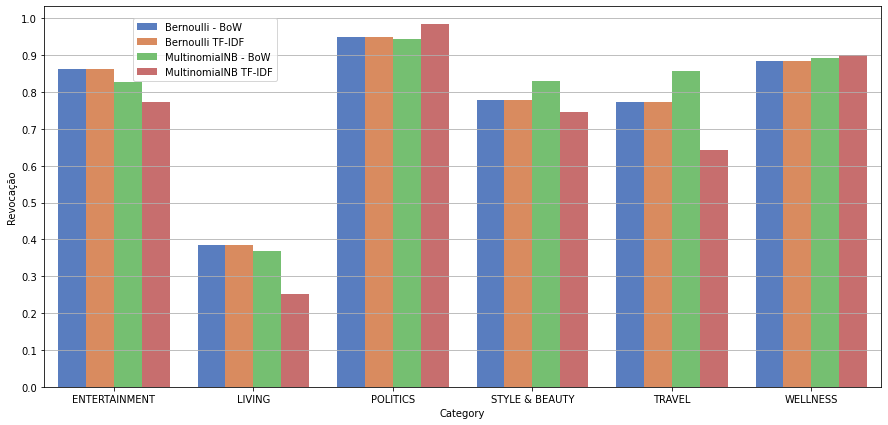

In [116]:
plt.figure(figsize=(15, 7))
plt.grid()
sns.barplot(x='Category', y='Revocação', hue='Modelos', data=report, palette='muted')
plt.legend(bbox_to_anchor=(0.1, 0.79))
plt.yticks(np.arange(0.0, 1.1, 0.1));
plt.savefig('recall.png')